# ChatGPT Usage Analysis Notebook

This notebook analyzes your ChatGPT conversation data exported from OpenAI. It provides insights into usage patterns, token consumption, estimated costs, and model preferences over time.

## 1. Notebook Parameters

Set the parameters for the analysis. These replace the command-line arguments from the original script.

In [1]:
# REQUIRED: Path to your exported ChatGPT data folder 
# This folder should contain the 'conversations.json' file.
convo_folder = "/Users/yuanpingsong/Desktop/repos/chatgpt-analytics/chatgpt_export"  # <--- !!! UPDATE THIS PATH !!!

# Timezone for converting timestamps (e.g., 'America/New_York', 'Europe/London', 'UTC')
user_timezone = "America/New_York"

# Aggregation period for model usage charts: 'D' (Daily), 'W' (Weekly), 'M' (Monthly)
aggregation_period_charts = "M"

## 2. Imports

Import necessary libraries. We'll use `pandas` for data manipulation, `matplotlib` for plotting, and `tiktoken` for token counting if available.

In [2]:
import argparse
import json
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime, timezone
from typing import Dict, Iterable, List, Optional

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pytz
from matplotlib.dates import DateFormatter

%matplotlib inline

import tiktoken
_ = tiktoken.get_encoding("cl100k_base")

## 3. Global Constants and Configuration

In [3]:
# price in USD per million tokens
# https://openai.com/api/pricing/
MODEL_PRICING = {
    "gpt-4-1": {"input": 2, "output": 8},
    "gpt-4-1-mini": {"input": 0.4, "output": 1.6},
    "gpt-4-1-nano": {"input": 0.1, "output": 0.4},
    "gpt-4-5": {"input": 75, "output": 150 },
    "gpt-4o": {"input": 2.5, "output": 10 },
    "gpt-4o-mini": {"input": 0.15, "output": 0.6 },
    "o1": { "input": 15, "output": 60 },
    "o1-pro": { "input": 150, "output": 600},
    "o3": { "input": 10, "output": 40 },
    "o4-mini": { "input": 1.1, "output": 4.4},
    "o3-mini": { "input": 1.1, "output": 4.4},
    "o1-mini": { "input": 1.1, "output": 4.4},
    "codex-mini": {"input": 1.5, "output": 6},
    # source: https://web.archive.org/web/20240202001102/https://openai.com/pricing/
    "gpt-4-turbo": {"input": 10, "output": 30},
    "gpt-4": {"input": 30, "output": 60},
    "gpt-3.5-turbo": {"input": 0.5, "output": 1.5},
}

## 4. DataClass Definition

Define a dataclass to represent individual messages.

In [4]:
@dataclass
class Message:
    conv_id: str
    msg_id: str
    parent_id: Optional[str]
    children: List[str]
    role: str
    create_time: float
    content: str
    content_type: str
    model: Optional[str]
    metadata: Dict
    tokens: int = 0
    context_tokens: int = 0

## 5. Helper Functions

These functions handle data loading, parsing, tokenization, aggregation, and plotting.

In [5]:
def load_conversations(path: str) -> List[dict]:
    with open(f"{path}/conversations.json", "r", encoding="utf-8") as f:
        return json.load(f)


def extract_messages(convs: Iterable[dict]) -> List[Message]:
    messages: List[Message] = []
    for idx, conv in enumerate(convs):
        conv_id = str(conv.get("conversation_id", idx))
        mapping = conv.get("mapping", {})
        for node_id, node in mapping.items():
            msg = node.get("message")
            if not msg:
                continue
            author = msg.get("author", {}).get("role", "")
            ts = msg.get("create_time")
            if ts is None:
                continue
            content = msg.get("content", {})
            ctype = content.get("content_type", "text")
            text = ""
            if isinstance(content, dict):
                if ctype == "text" and isinstance(content.get("parts"), list):
                    # a message can have images, we will ignore them for now
                    parts = list(filter(lambda x: isinstance(x, str), content.get("parts", [])))
                    text = "\n".join(parts)
                else:
                    text = content.get("text") or ""
                    parts = list(filter(lambda x: isinstance(x, str), content.get("parts", [])))
                    text = text or "\n".join(parts)
            model = msg.get("metadata", {}).get("model_slug")
            metadata = msg.get("metadata", {})
            messages.append(
                Message(
                    conv_id=conv_id,
                    msg_id=node_id,
                    parent_id=node.get("parent"),
                    children=node.get("children", []),
                    role=author,
                    create_time=ts,
                    content=text,
                    content_type=ctype,
                    model=model,
                    metadata=metadata,
                )
            )
    return messages


def assign_user_models(messages: List[Message]) -> None:
    model_map = {m.parent_id: m.model for m in messages if m.role == "assistant"}
    for m in messages:
        if m.role == "user" and not m.model:
            m.model = model_map.get(m.msg_id)
    for m in messages:
        if m.tokens == 0:
            m.tokens = token_counter(m.content, m.model)


def token_counter(text: str, model: Optional[str]) -> int:
    if not text:
        return 0
    encoding = None
    if tiktoken is not None and model:
        try:
            encoding = tiktoken.encoding_for_model(model)
        except Exception:
            pass
    if encoding:
        try:
            return len(encoding.encode(text))
        except Exception:
            pass
    # simple heuristic fallback ~4 chars per token
    return max(1, int(len(text) / 4))


def calculate_conversation_tokens(messages: List[Message]) -> Dict[str, Dict[str, int]]:
    """
    Calculate actual input/output tokens for each message considering conversation context.
    
    In conversational AI:
    - Each assistant response uses the entire conversation history as input context
    - User messages don't incur API costs (they're just added to context)
    - Input tokens = all previous messages in the conversation
    - Output tokens = only the current assistant response
    """
    conv_map: Dict[str, Dict[str, Message]] = defaultdict(dict)
    for msg in messages:
        conv_map[msg.conv_id][msg.msg_id] = msg

    token_data: Dict[str, Dict[str, int]] = {}

    def traverse(cdict: Dict[str, Message], mid: str, context_tokens: int) -> None:
        msg = cdict[mid]
        msg.context_tokens = context_tokens
        # come up with a conservative estimate of token usage
        # tools calls, summarizations may consume additional tokens not captured here
        if msg.role == "assistant" and msg.content_type == "text":
            input_tokens = context_tokens
            output_tokens = msg.tokens
            thinking_tokens = 0

            is_reasoning_model = msg.model and msg.model.startswith("o")
            if is_reasoning_model:
                # estimate the number of thinking tokens
                thinking_multiplier = 3
                # for o3, we use a high multiplier because it includes tool use.
                if "high" in msg.model or "o3" in msg.model:
                    thinking_multiplier = 5
                if "low" in msg.model:
                    thinking_multiplier = 1.5

                thinking_tokens = output_tokens * thinking_multiplier
        else:
            input_tokens = 0
            output_tokens = 0
            thinking_tokens = 0
        token_data[mid] = {
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "thinking_tokens": thinking_tokens,
            "total_tokens": input_tokens + output_tokens + thinking_tokens,
        }
        next_ctx = context_tokens + msg.tokens
        for child_id in msg.children:
            child = cdict.get(child_id)
            if child:
                traverse(cdict, child_id, next_ctx)

    for conv_id, cdict in conv_map.items():
        roots = [m for m in cdict.values() if not m.parent_id or m.parent_id not in cdict]
        for r in roots:
            traverse(cdict, r.msg_id, 0)

    return token_data


def build_dataframe(messages: Iterable[Message], tz: str) -> pd.DataFrame:
    messages_list = list(messages)
    token_data = calculate_conversation_tokens(messages_list)
    
    rows = []
    for msg in messages_list:
        local_dt = (
            datetime.fromtimestamp(msg.create_time, tz=timezone.utc)
            .astimezone(pytz.timezone(tz))
        )
        
        msg_tokens = token_data.get(msg.msg_id, {"input_tokens": 0, "output_tokens": 0, "thinking_tokens": 0, "total_tokens": 0})
        
        rows.append(
            {
                "conv_id": msg.conv_id,
                "msg_id": msg.msg_id,
                "role": msg.role,
                "model": msg.model,
                "content": msg.content,
                "content_type": msg.content_type,
                "dt": local_dt,
                "metadata": msg.metadata,
                "tokens": msg.tokens,
                "input_tokens": msg_tokens["input_tokens"],
                "output_tokens": msg_tokens["output_tokens"],
                "thinking_tokens": msg_tokens["thinking_tokens"],
                "total_tokens": msg_tokens["total_tokens"],
            }
        )
    df = pd.DataFrame(rows)
    df["date"] = df["dt"].dt.date
    return df


def count_deep_research_results(df: pd.DataFrame) -> pd.Series:
    def is_deep_research_result(row: pd.Series) -> bool:
        meta = row.get("metadata", {}) or {}
        is_async_task = "async_task_id" in meta
        is_deep_research_task = is_async_task and meta["async_task_id"].startswith("deepresch_")
        is_deep_research_result = is_async_task and meta.get("is_async_task_result_message", False)
        return is_deep_research_result

    return df.apply(is_deep_research_result, axis=1)


def aggregate_daily(df: pd.DataFrame) -> pd.DataFrame:
    agg = (
        df.groupby("date")
        .agg(
            conversations=("conv_id", lambda x: x.nunique()),
            user_messages=("role", lambda x: (x == "user").sum()),
            input_tokens=("input_tokens", "sum"),
            output_tokens=("output_tokens", "sum"),
        )
        .reset_index()
    )
    return agg


def aggregate_by_model(df: pd.DataFrame) -> pd.DataFrame:
    agg = (
        df.groupby("model")
        .agg(
            conversations=("conv_id", lambda x: x.nunique()),
            messages=("msg_id", "count"),
            input_tokens=("input_tokens", "sum"),
            output_tokens=("output_tokens", "sum"),
            thinking_tokens=("thinking_tokens", "sum"), # Added for consistency
            total_tokens=("total_tokens", "sum") # Added for consistency
        )
        .reset_index()
    )
    return agg


def aggregate_by_date_and_model(df: pd.DataFrame, period: str = "D") -> pd.DataFrame:
    """
    Aggregate data by date and model for stacked area charts.
    
    Args:
        df: DataFrame with message data
        period: Aggregation period - "D" for daily, "W" for weekly, "M" for monthly
    """
    df_copy = df.copy()
    
    if period == "D":
        df_copy["period"] = df_copy["date"]
    elif period == "W":
        df_copy["period"] = pd.to_datetime(df_copy["date"]).dt.to_period("W").dt.start_time.dt.date
    elif period == "M":
        df_copy["period"] = pd.to_datetime(df_copy["date"]).dt.to_period("M").dt.start_time.dt.date
    else:
        raise ValueError(f"Unsupported period: {period}. Use 'D', 'W', or 'M'.")
    
    # Note: Original script had print statements here, which are useful for debugging
    # but might be removed for a cleaner final notebook.
    user_messages_agg = df_copy[df_copy["role"] == "user"].groupby(["period", "model"]).agg(
        user_messages=("msg_id", "count")
    ).reset_index() # Reset index to make 'period' and 'model' columns for merging
    # print("User messages aggregation:")
    # print(user_messages_agg.head())

    model_agg = (
        df_copy.groupby(["period", "model"])
        .agg(
            messages=("msg_id", "count"),
            input_tokens=("input_tokens", "sum"),
            output_tokens=("output_tokens", "sum"),
            thinking_tokens=("thinking_tokens", "sum"),
            total_tokens=("total_tokens", "sum"),
        )
        .reset_index() # Reset index to make 'period' and 'model' columns for merging
    )
    
    # Merge user messages count with the main aggregation
    # Ensure to merge on both period and model to align correctly
    agg = pd.merge(model_agg, user_messages_agg, on=["period", "model"], how="left")
    agg['user_messages'] = agg['user_messages'].fillna(0).astype(int) # Fill NaN for models with no user messages in a period

    agg = agg.rename(columns={"period": "date"})
    
    return agg


def format_model_stats_display(model_stats: pd.DataFrame) -> pd.DataFrame:
    """Format model stats with token counts in millions for better readability."""
    display_stats = model_stats.copy()
    display_stats["input_tokens_M"] = (display_stats["input_tokens"] / 1_000_000).round(2)
    display_stats["output_tokens_M"] = (display_stats["output_tokens"] / 1_000_000).round(2)
    
    # Reorder columns to show millions first, then raw counts
    columns = ["model", "conversations", "messages", "input_tokens_M", "output_tokens_M"]
    # Add thinking and total tokens if they exist
    if "thinking_tokens" in display_stats.columns:
        display_stats["thinking_tokens_M"] = (display_stats["thinking_tokens"] / 1_000_000).round(2)
        columns.extend(["thinking_tokens_M"])
    if "total_tokens" in display_stats.columns:
        display_stats["total_tokens_M"] = (display_stats["total_tokens"] / 1_000_000).round(2)
        columns.extend(["total_tokens_M"])
        
    # Filter columns to only those present in display_stats
    columns = [col for col in columns if col in display_stats.columns]
    return display_stats[columns]


def estimate_cost(df: pd.DataFrame) -> pd.DataFrame:
    costs = []
    # Ensure that groupby includes all necessary token columns if they exist
    grouped_data = df.groupby("model")
    
    for model, data in grouped_data:
        if model is None: # Skip messages where model couldn't be determined
            continue
        if model == "research": # No API for deep research yet
            continue
            
        cleaned_model_name = model.replace("-high", "").replace("-preview", "").replace("-browsing", "").replace("-plugins", "")
        if "davinci" in cleaned_model_name:
            cleaned_model_name = "gpt-4"

        price = MODEL_PRICING.get(cleaned_model_name, {"input": 0.0, "output": 0.0})
        in_tok = data["input_tokens"].sum() / 1e6
        out_tok = data["output_tokens"].sum() / 1e6
        thinking_tok = data["thinking_tokens"].sum() / 1e6 if "thinking_tokens" in data.columns else 0
        
        cost = in_tok * price["input"] + out_tok * price["output"] + thinking_tok * price["output"]

        costs.append({
            "model": model, 
            "input_tokens (M)": round(in_tok, 3), 
            "output_tokens (M)": round(out_tok, 3), 
            "thinking_tokens (M)": round(thinking_tok, 3), 
            "cost_usd": round(cost, 2)
        })
    return pd.DataFrame(costs)


def subscription_value(df_cost: pd.DataFrame, months: int) -> pd.DataFrame:
    payg = df_cost["cost_usd"].sum()
    sub_cost = 20 * months
    return pd.DataFrame(
        {
            "period_months": [months],
            "pay_per_use_estimate_usd": [round(payg, 2)],
            "subscription_cost_usd": [sub_cost],
            "difference_usd": [round(sub_cost - payg, 2)],
        }
    )


def plot_heatmap(df: pd.DataFrame, year: int, column: str, title: str) -> None:
    df_year = df[df["date"].apply(lambda d: d.year == year)]
    if df_year.empty:
        print(f"No data available for {year} to plot heatmap: {title}")
        return
        
    counts = dict(zip(df_year["date"], df_year[column]))
    start = datetime(year, 1, 1).date()
    end = datetime(year, 12, 31).date()
    total_days = (end - start).days + 1
    date_range = [start + pd.Timedelta(days=i) for i in range(total_days)]
    data = []
    for dt_obj in date_range: # Renamed from dt to dt_obj to avoid conflict with df['dt']
        # Convert dt_obj (which is datetime.date from Timedelta) to match keys in counts (datetime.date from df['date'])
        week = ((dt_obj - start).days + start.weekday()) // 7
        day = dt_obj.weekday()
        count = counts.get(dt_obj, 0)
        data.append((week, day, count))
        
    weeks_in_year = (end - start).days // 7 + 1
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect("equal")
    vals = list(counts.values()) or [0]
    p90 = np.percentile(vals, 90) if vals else 1 # Ensure vals is not empty
    p90 = p90 if p90 > 0 else 1 # Ensure p90 is positive
    
    for week, day, count in data:
        color = plt.cm.Greens((count + 1) / p90) if count > 0 else "lightgray"
        rect = patches.Rectangle((week, day), 1, 1, linewidth=0.5, edgecolor="black", facecolor=color)
        ax.add_patch(rect)
        
    months_dates = [start + pd.Timedelta(days=i) for i in range(total_days) if (start + pd.Timedelta(days=i)).day == 1]
    for m_date in months_dates:
        week = ((m_date - start).days + start.weekday()) // 7 # Use start.weekday() to align month labels correctly
        plt.text(week + 0.5, 7.75, m_date.strftime("%b"), ha="center", va="center", fontsize=10)
        
    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks([])
    plt.yticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def plot_deep_research_by_month(df: pd.DataFrame, period: str = 'month') -> None:
    """Plot deep research runs by week or month from February 2025 onward.
    
    Args:
        df: DataFrame with conversation data
        period: 'week' or 'month' for aggregation period
    """
    if period not in ['week', 'month']:
        raise ValueError("period must be 'week' or 'month'")
        
    deep_research_mask = count_deep_research_results(df)
    deep_research_df = df[deep_research_mask].copy()
    
    # Ensure 'dt' column is timezone-aware for comparison
    # If 'dt' is already timezone-aware, this won't change it if tz matches.
    # If 'dt' is naive, this localizes it to UTC (consistent with fromtimestamp(ts, tz=timezone.utc))
    if deep_research_df['dt'].dt.tz is None:
        deep_research_df['dt'] = deep_research_df['dt'].dt.tz_localize('UTC') # Or use the notebook's tz parameter
        
    start_date = datetime(2025, 2, 1, tzinfo=timezone.utc)
    deep_research_df = deep_research_df[deep_research_df['dt'] >= start_date]
    
    if deep_research_df.empty:
        print("No deep research results found from February 2025 onward.")
        return
    
    # Group by week or month
    period_code = 'W' if period == 'week' else 'M'
    deep_research_df['period'] = deep_research_df['dt'].dt.to_period(period_code)
    period_counts = deep_research_df.groupby('period').size().reset_index(name='count')
    
    # Create complete range of periods from start to end
    min_period = deep_research_df['period'].min()
    max_period = deep_research_df['period'].max()
    all_periods = pd.period_range(start=min_period, end=max_period, freq=period_code)
    
    # Create dataframe with all periods and merge with actual counts
    all_periods_df = pd.DataFrame({'period': all_periods})
    period_counts = all_periods_df.merge(period_counts, on='period', how='left')
    period_counts['count'] = period_counts['count'].fillna(0).astype(int)
    period_counts['period_dt'] = period_counts['period'].dt.to_timestamp()
    
    # Adjust bar width based on period
    bar_width = 5 if period == 'week' else 20
    
    plt.figure(figsize=(12, 6))
    plt.bar(period_counts['period_dt'], period_counts['count'], 
            color='steelblue', alpha=0.7, width=bar_width)
    
    plt.title(f'Deep Research Runs by {period.capitalize()} (Feb 2025 onward)', fontsize=14, fontweight='bold')
    plt.xlabel(period.capitalize(), fontsize=12)
    plt.ylabel('Number of Deep Research Runs', fontsize=12)
    
    plt.xticks(period_counts['period_dt'], rotation=45)
    
    # Format x-axis labels based on period
    if period == 'week':
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d, %Y'))
    else:
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
    
    for i, (period_dt, count) in enumerate(zip(period_counts['period_dt'], period_counts['count'])):
        # Only show count labels for non-zero values to avoid clutter
        if count > 0:
            plt.text(period_dt, count + 0.1, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    total_runs = period_counts['count'].sum()
    # Calculate average only for periods with non-zero counts
    non_zero_counts = period_counts[period_counts['count'] > 0]['count']
    avg_per_period = non_zero_counts.mean() if len(non_zero_counts) > 0 else 0
    print(f"\nDeep Research Summary (Feb 2025 onward):")
    print(f"Total runs: {total_runs}")
    print(f"Average per {period} (excluding zeros): {avg_per_period:.1f}")
    print(f"Total {period}s: {len(period_counts)}")
    print(f"{period.capitalize()}s with runs: {len(non_zero_counts)}")


def plot_model_usage_over_time(df: pd.DataFrame, metric: str = "messages", 
                              percentage_stacked: bool = False, period: str = "W") -> None:
    """
    Plot stacked area chart showing model usage over time.
    Args:
        df: DataFrame with message data
        metric: Either "messages" or "tokens" to determine what to plot
        percentage_stacked: If True, create 100% stacked chart; if False, regular stacked
        period: Aggregation period - "D" for daily, "W" for weekly, "M" for monthly
    """
    agg_df = aggregate_by_date_and_model(df, period=period)
    
    if agg_df.empty:
        print(f"No data available for {metric} over time.")
        return
    
    if metric == "messages":
        value_col = "user_messages"
        ylabel = "Number of User Messages"
        title_base = "Model Usage Over Time (User Messages)"
    elif metric == "tokens":
        value_col = "total_tokens"
        ylabel = "Number of Tokens"
        title_base = "Model Usage Over Time (Total Tokens)"
    else:
        raise ValueError("metric must be either 'messages' or 'tokens'")
    
    if value_col not in agg_df.columns:
        print(f"Value column '{value_col}' not found in aggregated data. Available columns: {agg_df.columns}")
        if value_col == "user_messages" and "messages" in agg_df.columns:
            print("Falling back to 'messages' column for user messages count.")
            value_col = "messages" # Fallback if 'user_messages' was not correctly populated
        else:
            return
            
    period_labels = {"D": "Daily", "W": "Weekly", "M": "Monthly"}
    period_label = period_labels.get(period, period)
    title_base = f"{title_base} - {period_label}"
    
    pivot_df = agg_df.pivot(index='date', columns='model', values=value_col).fillna(0)
    if pivot_df.empty:
        print(f"Pivoted data is empty for metric {metric}.")
        return
        
    pivot_df.index = pd.to_datetime(pivot_df.index)
    
    row_sums = pivot_df.sum(axis=1)
    active_periods = row_sums[row_sums > 0]
    
    if active_periods.empty:
        print(f"No activity found for {metric}.")
        return
    
    first_active = active_periods.index.min()
    last_active = active_periods.index.max()
    pivot_df = pivot_df.loc[first_active:last_active]
    
    total_usage_sum = pivot_df.sum().sum()
    if total_usage_sum == 0:
        print(f"Total usage is zero for {metric}. Skipping model filtering.")
        models_to_keep = pivot_df.columns.tolist()
    else:
        total_usage = pivot_df.sum()
        min_threshold = total_usage.sum() * 0.01
        significant_models = total_usage[total_usage >= min_threshold].index
        
        model_presence = (pivot_df > 0).sum()
        min_periods = len(pivot_df) * 0.1
        active_models = model_presence[model_presence >= min_periods].index
        
        models_to_keep = list(set(significant_models) | set(active_models))
        if not models_to_keep:
             print(f"No models met significance/activity criteria for {metric}. Showing all models.")
             models_to_keep = pivot_df.columns.tolist()
        pivot_df = pivot_df[models_to_keep]

    if pivot_df.empty:
        print(f"Data became empty after model filtering for metric {metric}.")
        return
        
    model_totals = pivot_df.sum().sort_values(ascending=False)
    pivot_df = pivot_df[model_totals.index]
    
    if period == "M":
        for col in pivot_df.columns:
            if pivot_df[col].ne(0).any(): # Check if there's any non-zero data
                first_valid = pivot_df[col].ne(0).idxmax()
                last_valid = pivot_df[col].ne(0)[::-1].idxmax()
                if pd.notna(first_valid) and pd.notna(last_valid):
                    mask = (pivot_df.index >= first_valid) & (pivot_df.index <= last_valid)
                    pivot_df.loc[mask, col] = pivot_df.loc[mask, col].replace(0, np.nan).interpolate(method='linear').fillna(0)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    if percentage_stacked:
        row_sums_for_pct = pivot_df.sum(axis=1)
        # Avoid division by zero if a row sum is 0
        pivot_pct = pivot_df.div(row_sums_for_pct.replace(0, 1), axis=0) * 100 
        
        ax.stackplot(pivot_pct.index, *[pivot_pct[col] for col in pivot_pct.columns], 
                    labels=pivot_pct.columns, alpha=0.8)
        
        ylabel_text = f"Percentage of {ylabel}"
        title = f"{title_base} (100% Stacked)"
        ax.set_ylim(0, 100)
        ax.set_ylabel(f"{ylabel_text} (%)")
    else:
        ax.stackplot(pivot_df.index, *[pivot_df[col] for col in pivot_df.columns], 
                    labels=pivot_df.columns, alpha=0.8)
        
        title = title_base
        ax.set_ylabel(ylabel)
        
        if metric == "tokens":
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    if not pivot_df.empty and len(pivot_df.columns) > 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    if not pivot_df.empty:
        ax.set_xlim(pivot_df.index.min(), pivot_df.index.max())
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{title} Summary:")
    if not pivot_df.empty:
      print(f"Date range: {pivot_df.index.min().strftime('%Y-%m-%d')} to {pivot_df.index.max().strftime('%Y-%m-%d')}")
      print(f"Total {metric}: {pivot_df.sum().sum():,.0f}")
      print(f"Models included: {len(pivot_df.columns)}")
      print(f"Number of {period_label.lower()} periods: {len(pivot_df)}")
      print(f"\nTop models by {metric}:")
      for model, count in model_totals.head(5).items():
          total_model_sum = model_totals.sum()
          pct = (count / total_model_sum * 100) if total_model_sum > 0 else 0
          print(f"  {model}: {count:,.0f} ({pct:.1f}%)")
    else:
      print("No data to display in summary.")

## 6. Data Loading and Initial Processing

Load conversations, extract messages, assign models to user messages, and build the main DataFrame.

In [6]:
try:
    convs = load_conversations(convo_folder)
    msgs = extract_messages(convs)
    assign_user_models(msgs)
    df_main = build_dataframe(msgs, user_timezone)
    
    print(f"Successfully loaded and processed {len(df_main)} messages.")
    print("DataFrame head:")
    display(df_main.head())
except FileNotFoundError:
    print(f"Error: The conversations.json file was not found in '{convo_folder}'.")
    print("Please update the 'convo_folder' variable in the 'Notebook Parameters' cell to the correct path.")
    df_main = pd.DataFrame() # Create an empty DataFrame to prevent subsequent errors
except Exception as e:
    print(f"An error occurred during data loading and initial processing: {e}")
    df_main = pd.DataFrame()

Successfully loaded and processed 10514 messages.
DataFrame head:


,conv_id,msg_id,role,model,content,content_type,dt,metadata,tokens,input_tokens,output_tokens,thinking_tokens,total_tokens,date
0,6833f403-819c-800b-9872-21fde104ac25,fd94a0d4-6702-4679-b939-5bfa4c342a69,user,o4-mini-high,How to fix this issue?\n\nError while loading ...,text,2025-05-26 00:54:27.333000-04:00,"{'selected_github_repos': [], 'serialization_m...",56,0,0,0,0,2025-05-26
1,6833f403-819c-800b-9872-21fde104ac25,b0af6574-ac8a-4fef-bdd4-2196fabe567d,assistant,o4-mini-high,,thoughts,2025-05-26 00:54:39.599370-04:00,"{'reasoning_status': 'is_reasoning', 'citation...",0,0,0,0,0,2025-05-26
2,6833f403-819c-800b-9872-21fde104ac25,33ad035c-5af6-477d-8800-c2dadb656dd8,assistant,o4-mini-high,"{""search_query"":[{""q"":""[[GeneratorState]] is n...",code,2025-05-26 00:54:27.766307-04:00,"{'finish_details': {'type': 'stop', 'stop_toke...",22,0,0,0,0,2025-05-26
3,6833f403-819c-800b-9872-21fde104ac25,c0f7bef3-99d2-4dcb-8079-2cc1b243fe54,tool,o4-mini-high,,text,2025-05-25 22:14:59.276341-04:00,{'search_result_groups': [{'type': 'search_res...,0,0,0,0,0,2025-05-25
4,6833f403-819c-800b-9872-21fde104ac25,a3598f15-f8ed-4980-9ccd-ba7ff1e9765a,assistant,o4-mini-high,,thoughts,2025-05-26 00:54:39.599734-04:00,"{'reasoning_status': 'is_reasoning', 'citation...",0,0,0,0,0,2025-05-26


### Role Distribution
Show the distribution of messages by role (user, assistant, system, etc.).

In [7]:
if not df_main.empty:
    print("Message distribution by role:")
    display(df_main['role'].value_counts())
else:
    print("DataFrame is empty, skipping role distribution.")

Message distribution by role:


role
assistant    4901
user         2829
tool         2418
system        366
Name: count, dtype: int64

## 7. Perform Aggregations

Aggregate data daily and by model.

In [8]:
daily_aggregated_data = aggregate_daily(df_main)
model_aggregated_stats = aggregate_by_model(df_main)

print("Daily aggregated data (head):")
display(daily_aggregated_data.head())
print("\nModel aggregated statistics (head):")
display(model_aggregated_stats.head())

Daily aggregated data (head):


,date,conversations,user_messages,input_tokens,output_tokens
0,2023-02-05,1,10,14896,2711
1,2023-04-25,2,7,4361,2658
2,2023-05-16,5,8,807,807
3,2023-05-21,1,4,8850,4343
4,2023-05-22,1,2,11412,1860



Model aggregated statistics (head):


,model,conversations,messages,input_tokens,output_tokens,thinking_tokens,total_tokens
0,gpt-4,53,1445,10388194,249742,0,10637936
1,gpt-4-5,47,333,552613,66728,0,619341
2,gpt-4-browsing,2,25,20342,6255,0,26597
3,gpt-4-plugins,5,34,17555,4710,0,22265
4,gpt-4o,193,2820,23345191,650418,0,23995609


## 8. Estimate Costs and Subscription Value

Estimate potential costs based on token usage and compare with subscription value.

In [9]:
cost_estimates_df = estimate_cost(df_main)
# Calculate number of unique months with activity
if 'dt' in df_main.columns and not df_main['dt'].empty:
    num_months_activity = df_main["dt"].dt.to_period("M").nunique()
else:
    num_months_activity = 0
    
subscription_value_analysis_df = subscription_value(cost_estimates_df, num_months_activity)

print("Cost Estimates per Model:")
display(cost_estimates_df)
print("\nSubscription Value Analysis:")
display(subscription_value_analysis_df)

Cost Estimates per Model:


/var/folders/vr/5g0m6lgj5kg5d1m0xjwth5pm0000gn/T/ipykernel_67503/1784675252.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  num_months_activity = df_main["dt"].dt.to_period("M").nunique()


,model,input_tokens (M),output_tokens (M),thinking_tokens (M),cost_usd
0,gpt-4,10.388,0.250,0.000,326.63
1,gpt-4-5,0.553,0.067,0.000,51.46
2,gpt-4-browsing,0.020,0.006,0.000,0.99
3,gpt-4-plugins,0.018,0.005,0.000,0.81
4,gpt-4o,23.345,0.650,0.000,64.87
5,gpt-4o-mini,0.247,0.018,0.000,0.05
6,o1,1.012,0.106,0.318,40.58
7,o1-mini,0.000,0.002,0.007,0.04
8,o1-preview,0.257,0.054,0.163,16.89
9,o1-pro,12.963,0.808,2.424,3883.32



Subscription Value Analysis:


,period_months,pay_per_use_estimate_usd,subscription_cost_usd,difference_usd
0,25,4411.08,500,-3911.08


## 9. Visualizations

### 9.1. Usage Heatmaps
Visualize daily activity for conversations and user messages for a specified year.

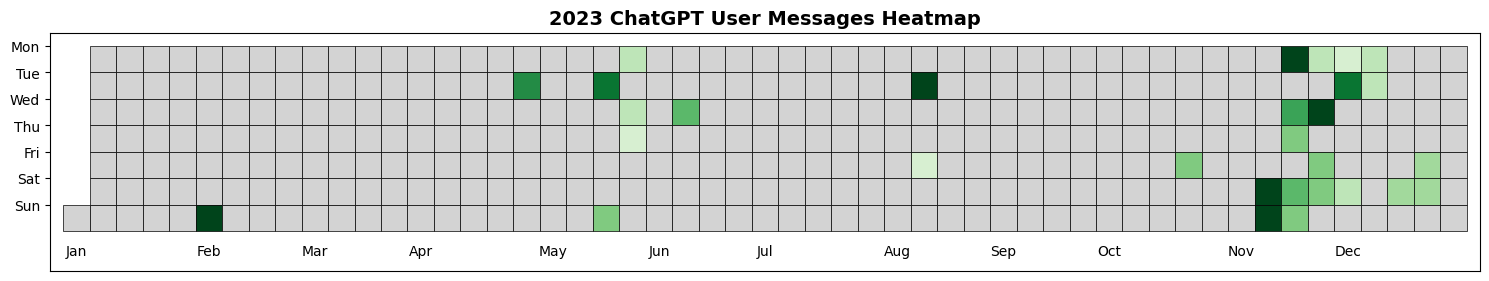

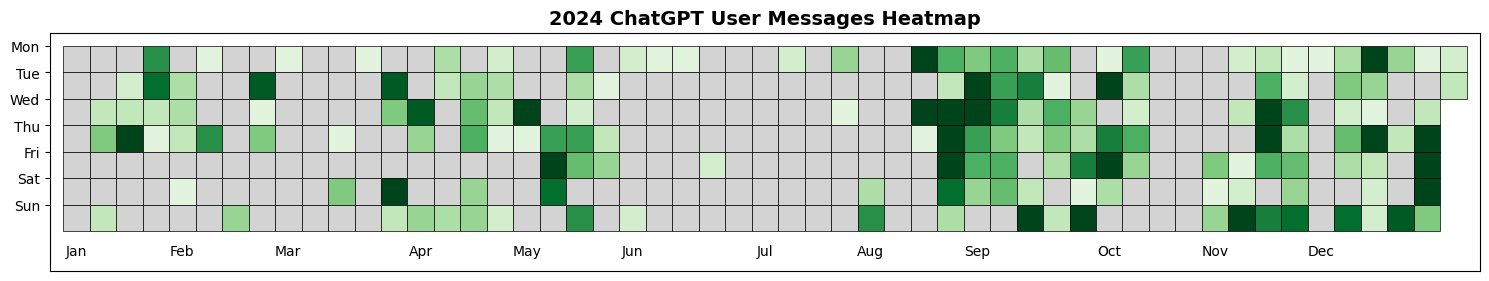

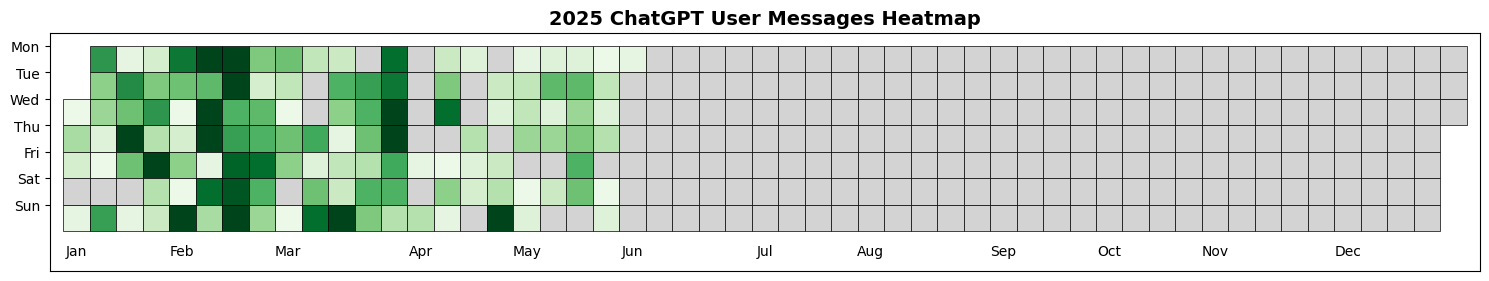

In [10]:
for year in [2023, 2024, 2025]:
    plot_heatmap(daily_aggregated_data, year, "user_messages", f"{year} ChatGPT User Messages Heatmap")

### 9.2. Formatted Model Statistics
Display detailed statistics per model, with token counts in millions for readability.

In [11]:
display(format_model_stats_display(model_aggregated_stats))

,model,conversations,messages,input_tokens_M,output_tokens_M,thinking_tokens_M,total_tokens_M
0,gpt-4,53,1445,10.39,0.25,0.00,10.64
1,gpt-4-5,47,333,0.55,0.07,0.00,0.62
2,gpt-4-browsing,2,25,0.02,0.01,0.00,0.03
3,gpt-4-plugins,5,34,0.02,0.00,0.00,0.02
4,gpt-4o,193,2820,23.35,0.65,0.00,24.00
5,gpt-4o-mini,1,62,0.25,0.02,0.00,0.26
6,o1,41,273,1.01,0.11,0.32,1.44
7,o1-mini,1,1,0.00,0.00,0.01,0.01
8,o1-preview,12,51,0.26,0.05,0.16,0.47
9,o1-pro,125,777,12.96,0.81,2.42,16.19


### 9.3. Deep Research Analysis
Plot the number of deep research runs by month (from February 2025 onward as per original script logic).

/var/folders/vr/5g0m6lgj5kg5d1m0xjwth5pm0000gn/T/ipykernel_67503/1370471663.py:405: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  deep_research_df['period'] = deep_research_df['dt'].dt.to_period(period_code)


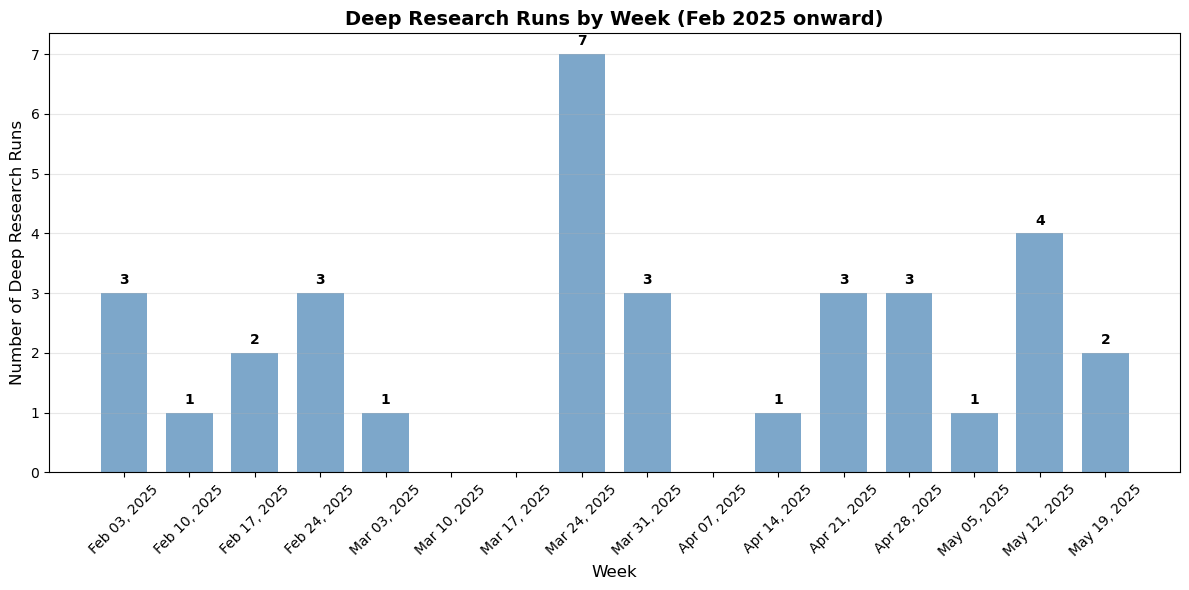


Deep Research Summary (Feb 2025 onward):
Total runs: 34
Average per week (excluding zeros): 2.6
Total weeks: 16
Weeks with runs: 13


In [12]:
plot_deep_research_by_month(df_main, period="week")

### 9.4. Model Usage Over Time
Stacked area charts showing model usage (by messages and tokens) over time. 
Aggregation period (Daily, Weekly, Monthly) and chart type (regular or 100% stacked) can be configured in the 'Notebook Parameters' section.

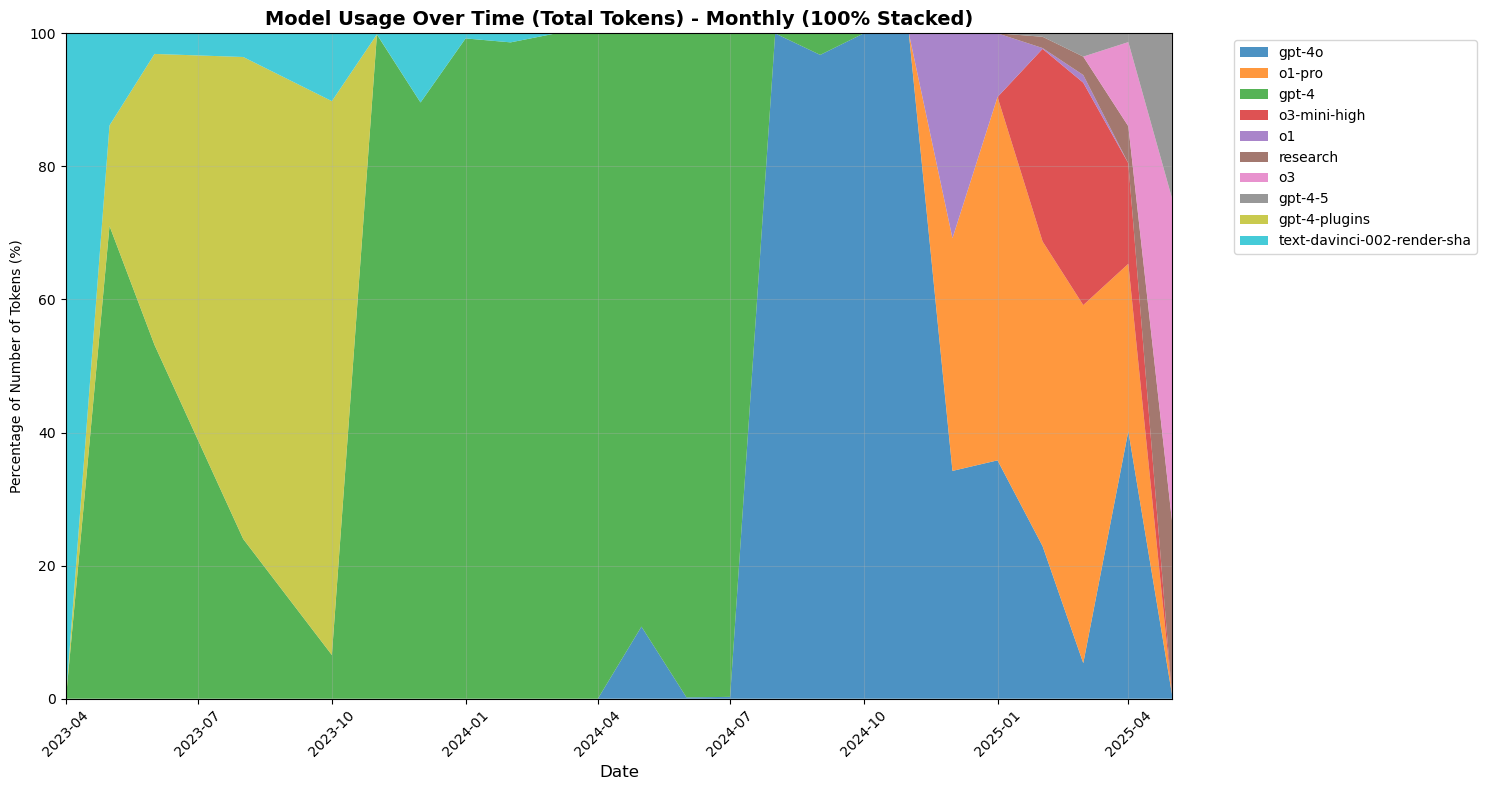


Model Usage Over Time (Total Tokens) - Monthly (100% Stacked) Summary:
Date range: 2023-04-01 to 2025-05-01
Total tokens: 68,192,421
Models included: 10
Number of monthly periods: 24

Top models by tokens:
  gpt-4o: 23,995,609 (38.7%)
  o1-pro: 16,194,403 (26.1%)
  gpt-4: 10,637,936 (17.2%)
  o3-mini-high: 7,426,059 (12.0%)
  o1: 1,435,312 (2.3%)


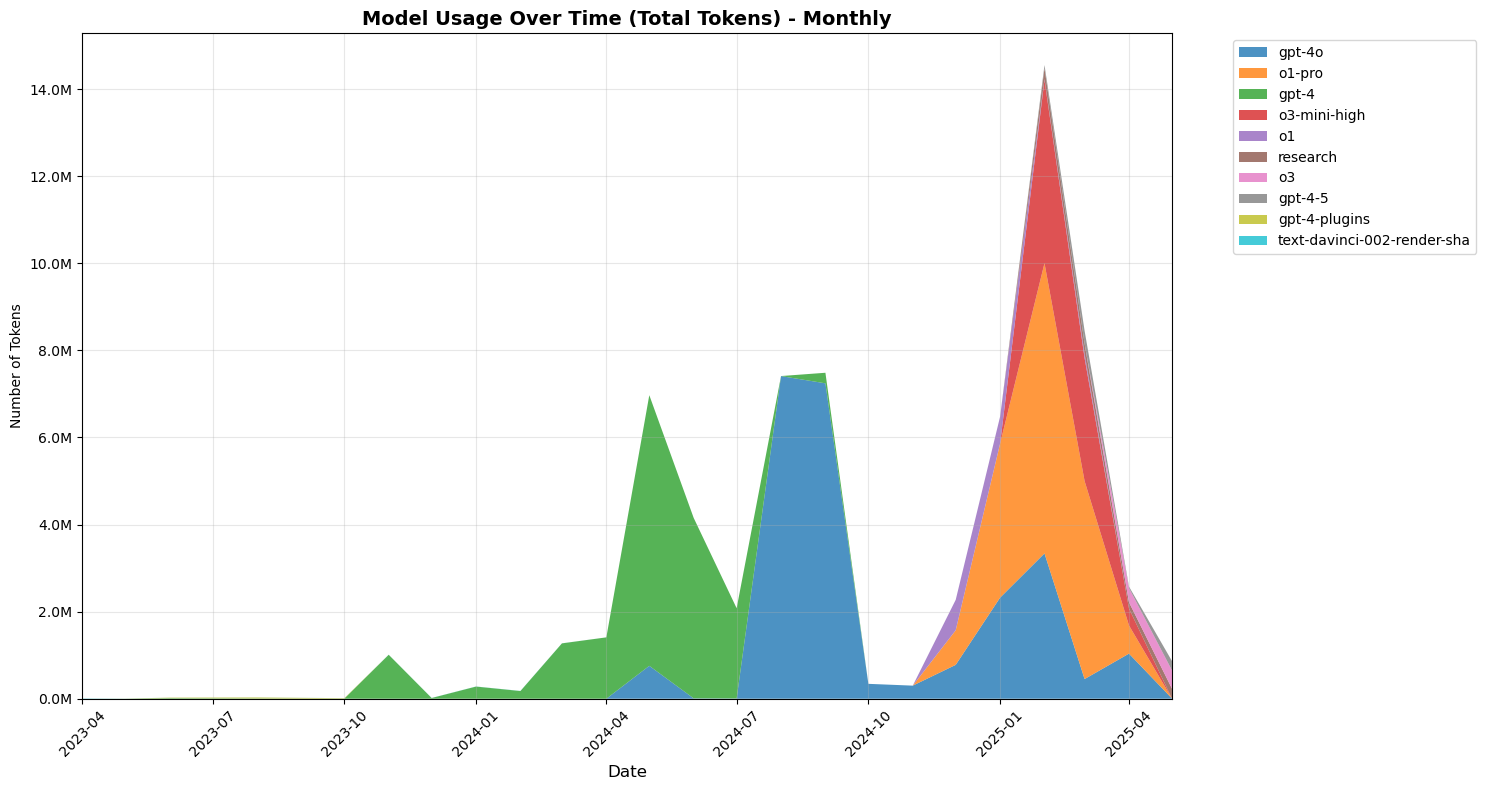


Model Usage Over Time (Total Tokens) - Monthly Summary:
Date range: 2023-04-01 to 2025-05-01
Total tokens: 68,192,421
Models included: 10
Number of monthly periods: 24

Top models by tokens:
  gpt-4o: 23,995,609 (38.7%)
  o1-pro: 16,194,403 (26.1%)
  gpt-4: 10,637,936 (17.2%)
  o3-mini-high: 7,426,059 (12.0%)
  o1: 1,435,312 (2.3%)


In [13]:
plot_model_usage_over_time(df_main, metric="tokens", 
                            percentage_stacked=True, 
                            period=aggregation_period_charts)

plot_model_usage_over_time(df_main, metric="tokens", 
                            percentage_stacked=False, 
                            period=aggregation_period_charts)

# plot_model_usage_over_time(df_main, metric="messages", 
#                             percentage_stacked=True, 
#                             period=aggregation_period_charts)

# plot_model_usage_over_time(df_main, metric="messages", 
#                             percentage_stacked=False, 
#                             period=aggregation_period_charts)

## 10. End of Analysis

This notebook has processed and visualized your ChatGPT usage data. Review the charts and tables above for insights.